You can download and run this notebook locally, or you can run it for free in a cloud environment using Colab or Sagemaker Studio Lab:

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/aylward/itkwidgets-MICCAI2023/blob/main/IDC_with_itkWidgets.ipynb)

[![Open In SageMaker Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github.com/aylward/itkwidgets-MICCAI2023/blob/main/IDC_with_itkWidgets.ipynb)

# Acknowledgement
This notebook is adapted from the TCIA notebook: https://github.com/kirbyju/TCIA_Notebooks/blob/main/TCIA_RTStruct_SEG_Visualization_with_itkWidgets.ipynb

# Summary
Access to large, high-quality data is essential for researchers to understand disease and precision medicine pathways, especially in cancer. However, HIPAA constraints make sharing medical images outside an individual institution a complex process. The [Imaging Data Commons (IDC)](https://datacommons.cancer.gov/repository/imaging-data-commons) and [The Cancer Imaging Archive (TCIA)](https://www.cancerimagingarchive.net/) are public services funded by the National Cancer Institute that addresses this challenge by providing hosting and de-identification services to take major burdens of data sharing off researchers.

## DICOM Image Objects
The IDC data is available as DICOM objects. A wide variety of toolkits are able to read DICOM images, but fewer are able to convert them into volumetric representations, and still fewer correctly maintain the metadata necessary to interpret how that volume maps into physical space (i.e., its origin, axis orientation, and the physical distance between its voxels).  Such information is critical to subsequent analysis of those images.

[ITK](https://github.com/InsightSoftwareConsortium/ITK) is used to read DICOM images.

## DICOM SEG and RTStruct Objects
There are often DICOM SEG (labelmap) and DICOM RTStruct (contour) files that provide annotations for the DICOM images.  Reading and mapping those objects onto medical images, and converting contours to labelmaps and preserving the origin, spacing, and direction information in those labelmaps can also be challenging.

Herein, we explore a common AI research workflow.  We demonstrate basic methods for itkWidgets using DICOM objects from IDC, converting them into images and labelmaps, and visualizing them within this Jupyter Notebook using itkWidgets.   

[RT-Utils](https://github.com/qurit/rt-utils) (built on top of pydicom) is used to convert RTStruct contours to labelmaps.

[pydicom-seg](https://github.com/razorx89/pydicom-seg) (also built on top of pydicom) is used to convert SEG labelmaps to images.

## Visualization
While Jupyter systems (JupyterLab, Jupyter Notebooks, Google Colab, AWS SageMaker, etc.) are outstanding tools for interactive programming and algorithm sharing, the ability to visualize data within them has traditionally be limited to plots and sparse 2D slices - which are insufficient when dealing with 3D clinical data. This limitation is particularly challenging when using cloud-based jupyter systems such as Google Colab and AWS SageMaker. 3D interactive visualization of data when using those cloud systems traditionally requires downloading that data to your local machine and then running a separate visualization application. itkWidgets addresses those visualization challenges by providing interacitve 3D (and 2D) visualizations within the cells of your Jupyter scripts.

[itkWidgets](https://github.com/InsightSoftwareConsortium/itkwidgets) is used to visualize images, point sets, and 3D geometry in Jupyter systems (Jupyter Notebooks, JupyterLab, AWS SageMaker, and Google Colab). Despite its name, itkWidgets does not require the use of ITK. It can directly visualize numpy arrays, torch tensors, DASK arrays, and a multitude of other Python data structures.

# Outline

1. Setup
2. IDC basics
3. Parse DICOM data using ITK
4. MatPlotLib - imshow
2. itkWidgets Basics
3. Use Cases
    1. Load and visualize DICOM Images and RTStruct objects
    2. Load and visualize DICOM Images and SEG objects

# 1. Setup

These are the initial steps for running notebooks within various Jupyter environments.

In [1]:
import os
import sys

In [3]:
# Upgrade pip, just in case...
!{sys.executable} -m pip install --upgrade -q pip

# If running on SageMaker or Studio Lab, install essential packages and extensions.
if "studio-lab-user" in os.getcwd():
    print("Upgrading dependencies")
    !conda install --yes -q --prefix {sys.prefix} -c conda-forge opencv nodejs
    
# This is the installation required for itkWidgets.
!{sys.executable} -m pip install --upgrade --pre -q "itkwidgets[all]>=1.0a23" imjoy_elfinder

# Install itk for DICOM I/O and for reading DICOM into an itkImage 
#   that manages all DICOM field values, include acquistion details 
#   such as voxel image, image orientation, and image directions,
#   which are critical to image processing and display
!{sys.executable} -m pip install --upgrade -q --pre "itk>5.3.0"

# Install rt-utils for reading DICOM RT-Struct objects.
!{sys.executable} -m pip install --upgrade -q rt-utils

# Install pydicom-seg for reading DICOM SEG objects.
!{sys.executable} -m pip install --upgrade -q pydicom-seg

In [2]:
import glob

import numpy as np

import pandas as pd

# Include ITK for DICOM reading.
import itk

# Include numpy which is used by pydicom-seg and rt_utils.
import numpy as np

# Pydicom-Seg is a layer on top of pydicom that handles DICOM SEG objects.
import pydicom
import pydicom_seg

# RT-Utils is a layer on top of pydicom that provides a convenient way to read RT-STRUCT DICOM contours and
#   generate labelmaps from them.  Labelmaps are needed for most deep learning segmentation tasks.
from rt_utils import RTStructBuilder

# This is the most common import command for itkWidgets.
#   The view() function opens an interactive viewer for 2D and 3D
#   data in a variety of formats.
from itkwidgets import view

# On some systems there are additional steps:

If you do not see a blue 'ImJoy' icon on the menu bar in this notebook:
   1) Google CoLab: The following does not apply to Google CoLab - it will not show an ImJoy and all
      should work without modification.
   2) Enable Extensions:  Many Jupyter Lab systems disable jupyter extensions by default,
      and they must be enabled for this notebook to work. Typically this is accomplished using the 
      Jupyter interface to select the extension manager (left-hand side, icon that looks like a piece
      of a puzzle) and select the Enable button if it appears.
   3) It may be necessary to install imjoy_elfinder 'pip install imjoy_elfinder'
   4) It may be necessary to restart the notebook / environment after these steps

# 2. IDC Basics


In [4]:
# Get manifest
# issue s5cmd command to store in ./data
# Follow instruction from IDC tutorials
!cd data;wget https://github.com/peak/s5cmd/releases/download/v2.2.2/s5cmd_2.2.2_Linux-64bit.tar.gz
!cd data;tar xvfpz s5cmd_2.2.2_Linux-64bit.tar.gz
!cd data;./s5cmd --no-sign-request --endpoint-url https://s3.amazonaws.com run ../study_manifest_aws.s5cmd

# 3. Parse DICOM data using ITK

In [3]:
# Read relevant series information from a directory of dicom files
# Returns a pandas DataFrame
def read_series_data(dicom_dir):
    # Read series UIDs from dicom_dir
    seriesNamesReader = itk.GDCMSeriesFileNames.New()
    seriesNamesReader.SetUseSeriesDetails(True)
    seriesNamesReader.SetDirectory(dicom_dir)
    seriesUIDs = seriesNamesReader.GetSeriesUIDs()
    
    # Create list of FileNames and Modalities for each seriesUID
    seriesFileNames = []
    seriesModalities = []
    dicomIO = itk.GDCMImageIO.New()
    for suid in seriesUIDs:
        seriesFileNames.append(list(seriesNamesReader.GetFileNames(suid)))
        dicomIO.SetFileName(seriesFileNames[-1][0])  # Read modality from first file in each series
        dicomIO.ReadImageInformation()               # Only read the DICOM tags, not the pixel data
        metadata = dicomIO.GetMetaDataDictionary()   # Acccess the DICOM tags via a dictionary
        modality = metadata['0008|0060']             # DICOM tag for Modality
        seriesModalities.append(str(modality))
    seriesData = pd.DataFrame({'UID': seriesUIDs, 'FileNames': seriesFileNames, 'Modality': seriesModalities})
    return seriesData

In [4]:
series_data = read_series_data('./data')

In [5]:
print(series_data)

                                                 UID  \
0  1.2.276.0.7230010.3.1.3.0.10926.1415313934.845...   
1  1.2.276.0.7230010.3.1.3.0.10953.1415313952.202...   
2  1.2.276.0.7230010.3.1.3.0.10975.1415313969.658...   
3  1.2.276.0.7230010.3.1.3.0.10998.1415313986.834...   
4  1.2.276.0.7230010.3.1.3.0.11020.1415314004.305...   
5  1.2.276.0.7230010.3.1.3.0.11044.1415314021.713...   
6  1.2.276.0.7230010.3.1.3.0.26655.1427919632.692...   
7  1.2.276.0.7230010.3.1.3.0.26680.1427919659.772...   
8  1.2.276.0.7230010.3.1.3.0.26703.1427919686.825...   
9  1.3.6.1.4.1.14519.5.2.1.4320.7007.113686129632...   

                                           FileNames Modality  
0  [./data/74e49111-7a78-48a0-ae3c-8dae264d2a81.dcm]     SEG   
1  [./data/4abeb64d-5450-44f1-9cb1-2fa81edee3e2.dcm]     SEG   
2  [./data/677324c2-ebbe-477f-b7e2-c382aead758c.dcm]     SEG   
3  [./data/9764c5e9-a9fa-42c2-af1b-cd1a8550220b.dcm]     SEG   
4  [./data/07f1c2dc-892d-4433-9f63-3a201ffcac69.dcm]     SEG   

In [6]:
fnames = series_data.loc[series_data['Modality'] == 'CT', 'FileNames'].tolist()[0]
ct_img = itk.ImageSeriesReader(FileNames=fnames)

In [7]:
ct_array = itk.GetArrayFromImage(ct_img)

# 6. Read a DICOM SEG object

In [8]:
def read_seg_object(fileName):
    pydicom_reader = pydicom.dcmread(fileName)
    seg_reader = pydicom_seg.MultiClassReader()
    seg_obj = seg_reader.read(pydicom_reader)

    # Convert the DICOM SEG object into an itk image, with correct voxel origin, spacing, and directions in physical space.
    seg_image = itk.GetImageViewFromArray(seg_obj.data.astype(np.float32))
    seg_image.SetOrigin(seg_obj.origin)
    seg_image.SetSpacing(seg_obj.spacing)
    seg_image.SetDirection(seg_obj.direction)
    return seg_image

In [10]:
segFileName = series_data['FileNames'][0][0]
print(segFileName)
seg_img0 = read_seg_object(segFileName)

./data/74e49111-7a78-48a0-ae3c-8dae264d2a81.dcm


In [11]:
seg_array0 = itk.GetArrayFromImage(seg_img0)

# 7. Visualize CT with SEG data overlaid

## 7a. Matplotlib: imshow()

In [13]:
from matplotlib import pyplot as plt

FigureCanvasAgg is non-interactive, and thus cannot be shown


<Figure size 1000x10000 with 0 Axes>

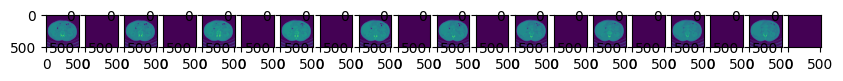

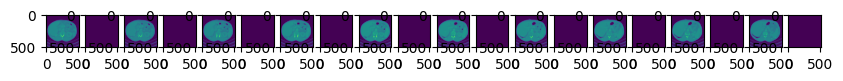

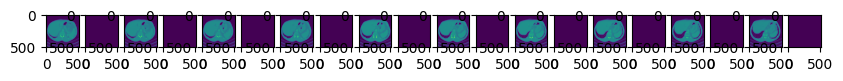

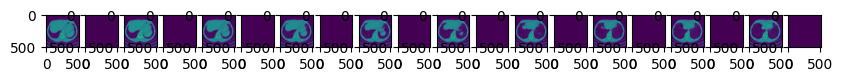

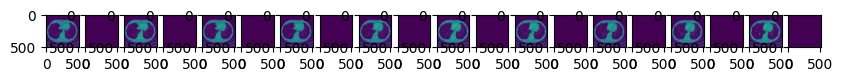

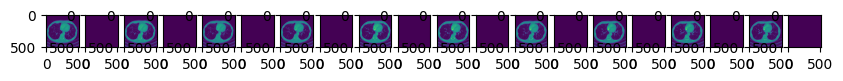

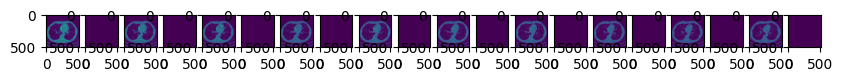

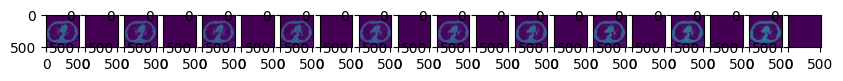

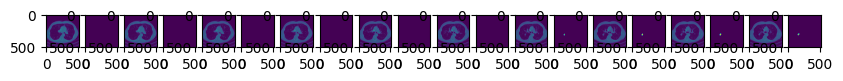

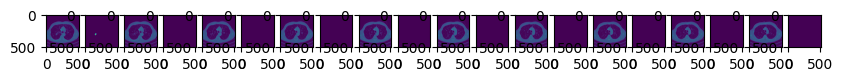

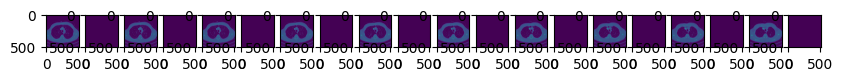

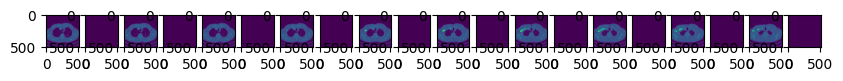

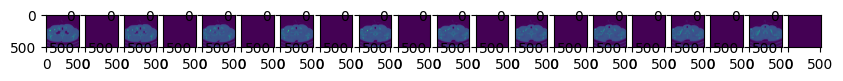

In [14]:
numx = 10
numy = 10
numplts = numx*numy-1
slice_step = int(np.ceil(ct_array.shape[0]/numplts))
slice_num = 0
fig = plt.figure(figsize=(10,10*numx))
while slice_num < ct_array.shape[0]:
    if slice_num % numx == 0:
        fig.show()
        fig = plt.figure(figsize=(10,15*numx))
    fig.add_subplot(1,numx*2,slice_num%numx*2+1)
    plt.imshow(ct_array[slice_num,:,:])
    fig.add_subplot(1,numx*2,slice_num%numx*2+2)
    plt.imshow(seg_array0[slice_num,:,:])
    slice_num += 1

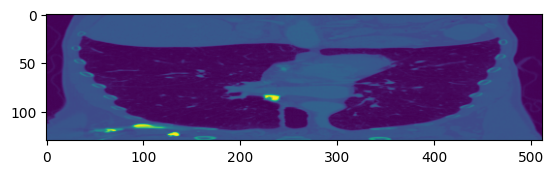

In [15]:
plt.imshow(ct_array[:,256,:])

In [16]:
ct_img.GetSpacing()

itkVectorD3 ([0.664062, 0.664062, 3])

## 7.b. itkWidgets: view()

In [17]:
from itkwidgets import view


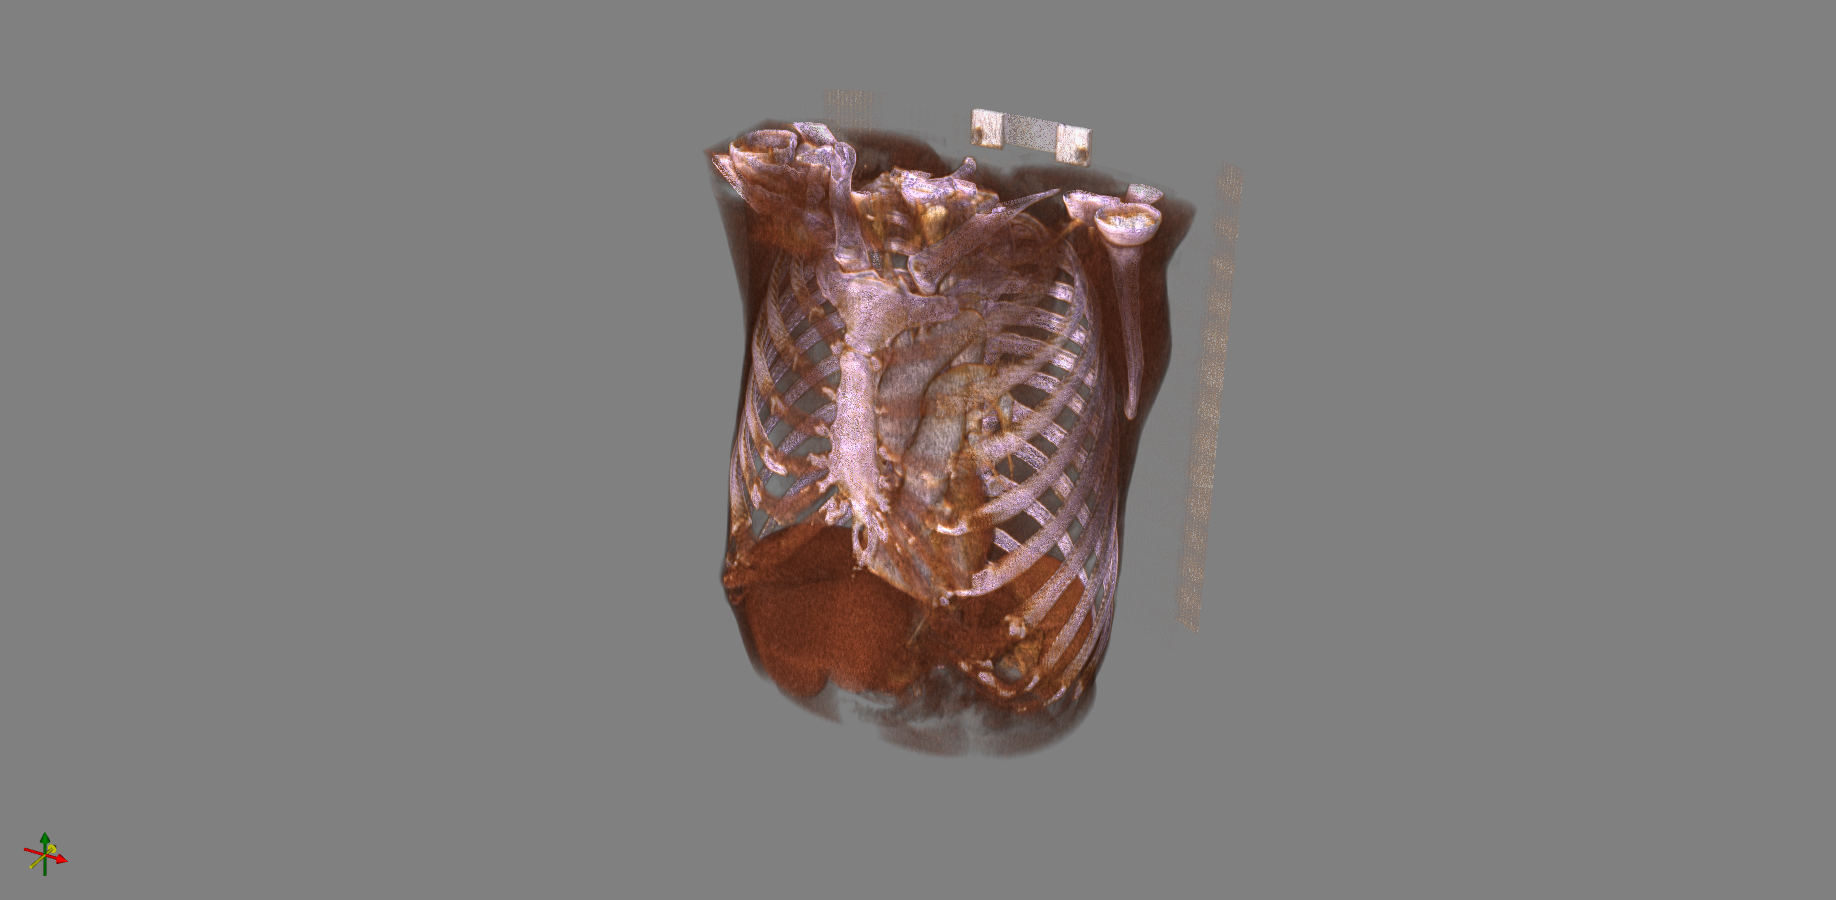
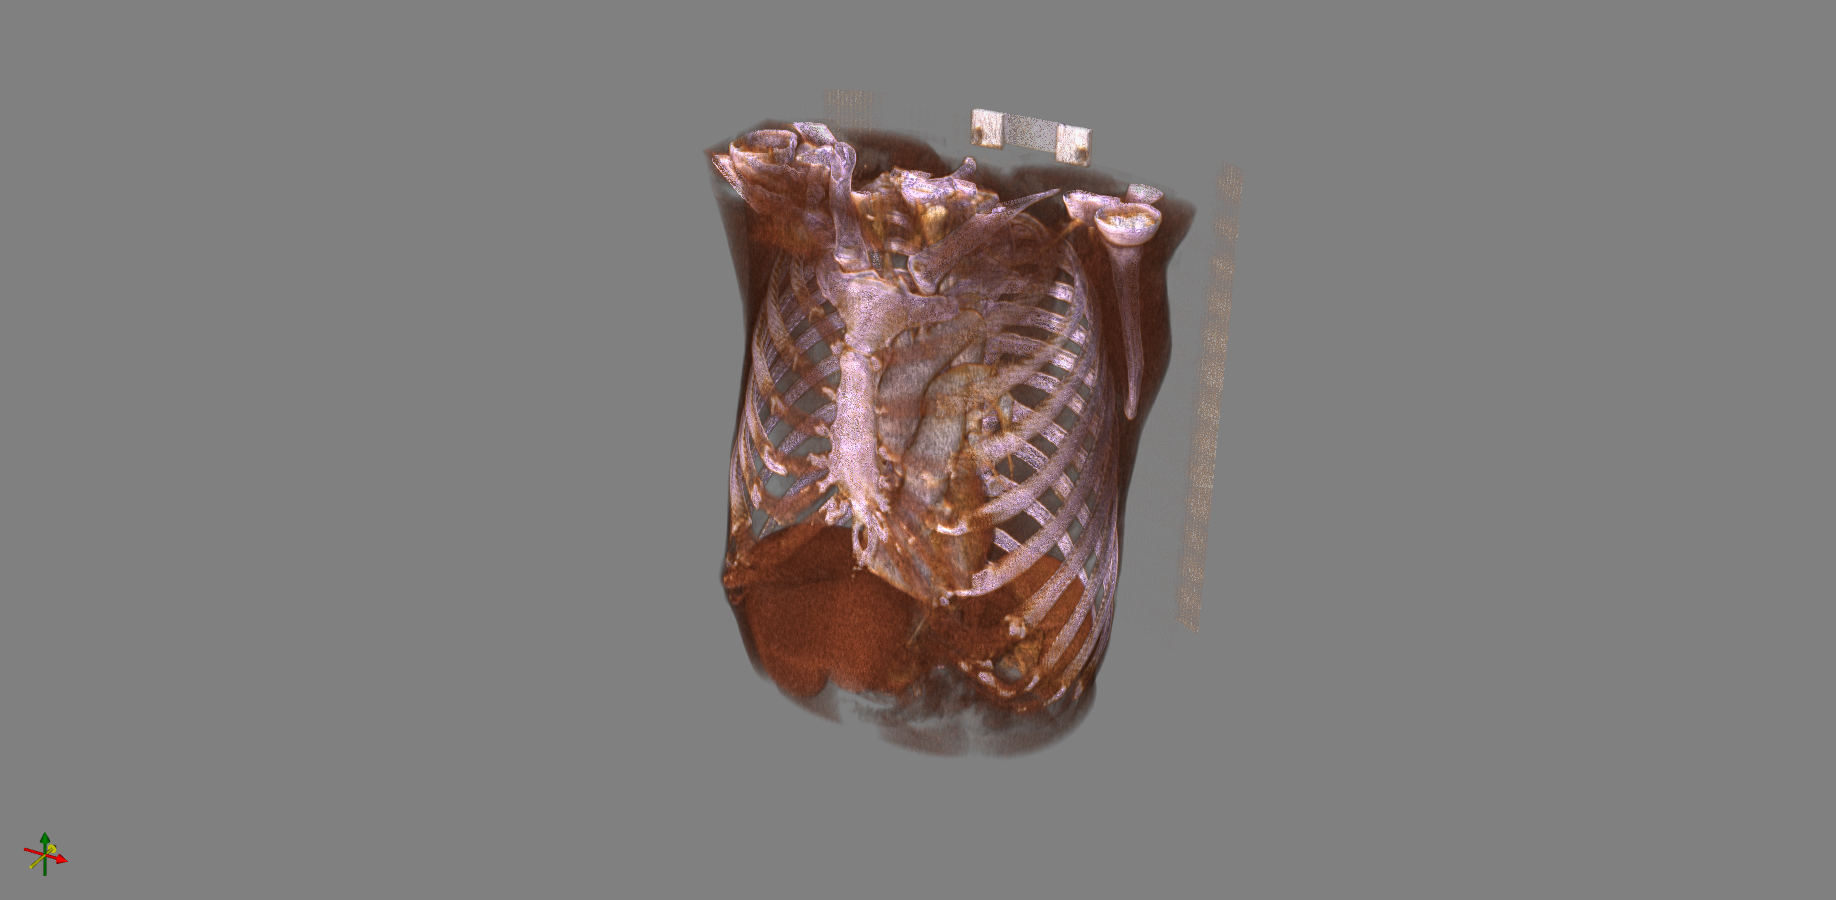

<IPython.core.display.Javascript object>

In [27]:
viewer1 = view(image=ct_img, label_image=seg_img0)

In [28]:
viewer1.set_image_color_map("CT-Chest-Vessels")
viewer1.set_image_color_range([0,400])
viewer1.set_view_mode("Volume")
viewer1.set_ui_collapsed(False)
viewer1.set_label_image_weights([0.5,1])
viewer1.set_image_gradient_opacity_scale(0.01)

In [29]:
viewer1.set_image_color_map("Grayscale")
viewer1.set_image_color_range([0,400])
viewer1.set_label_image_blend(0.9)
viewer1.set_view_mode("ZPlane")
viewer1.set_z_slice(353)
viewer1.set_ui_collapsed(False)

# 8. View the overlap of two SEG objects

In [21]:
segFileName = series_data['FileNames'][8][0]
print(segFileName)
seg_img1 = read_seg_object(segFileName)

seg_array1 = itk.GetArrayFromImage(seg_img1)

seg_array_sum = seg_array0 + 2 * seg_array1
seg_img_sum = itk.GetImageFromArray(seg_array_sum)
seg_img_sum.CopyInformation(seg_img1)

./data/a229f620-fd48-4525-830c-549cbf3f1514.dcm



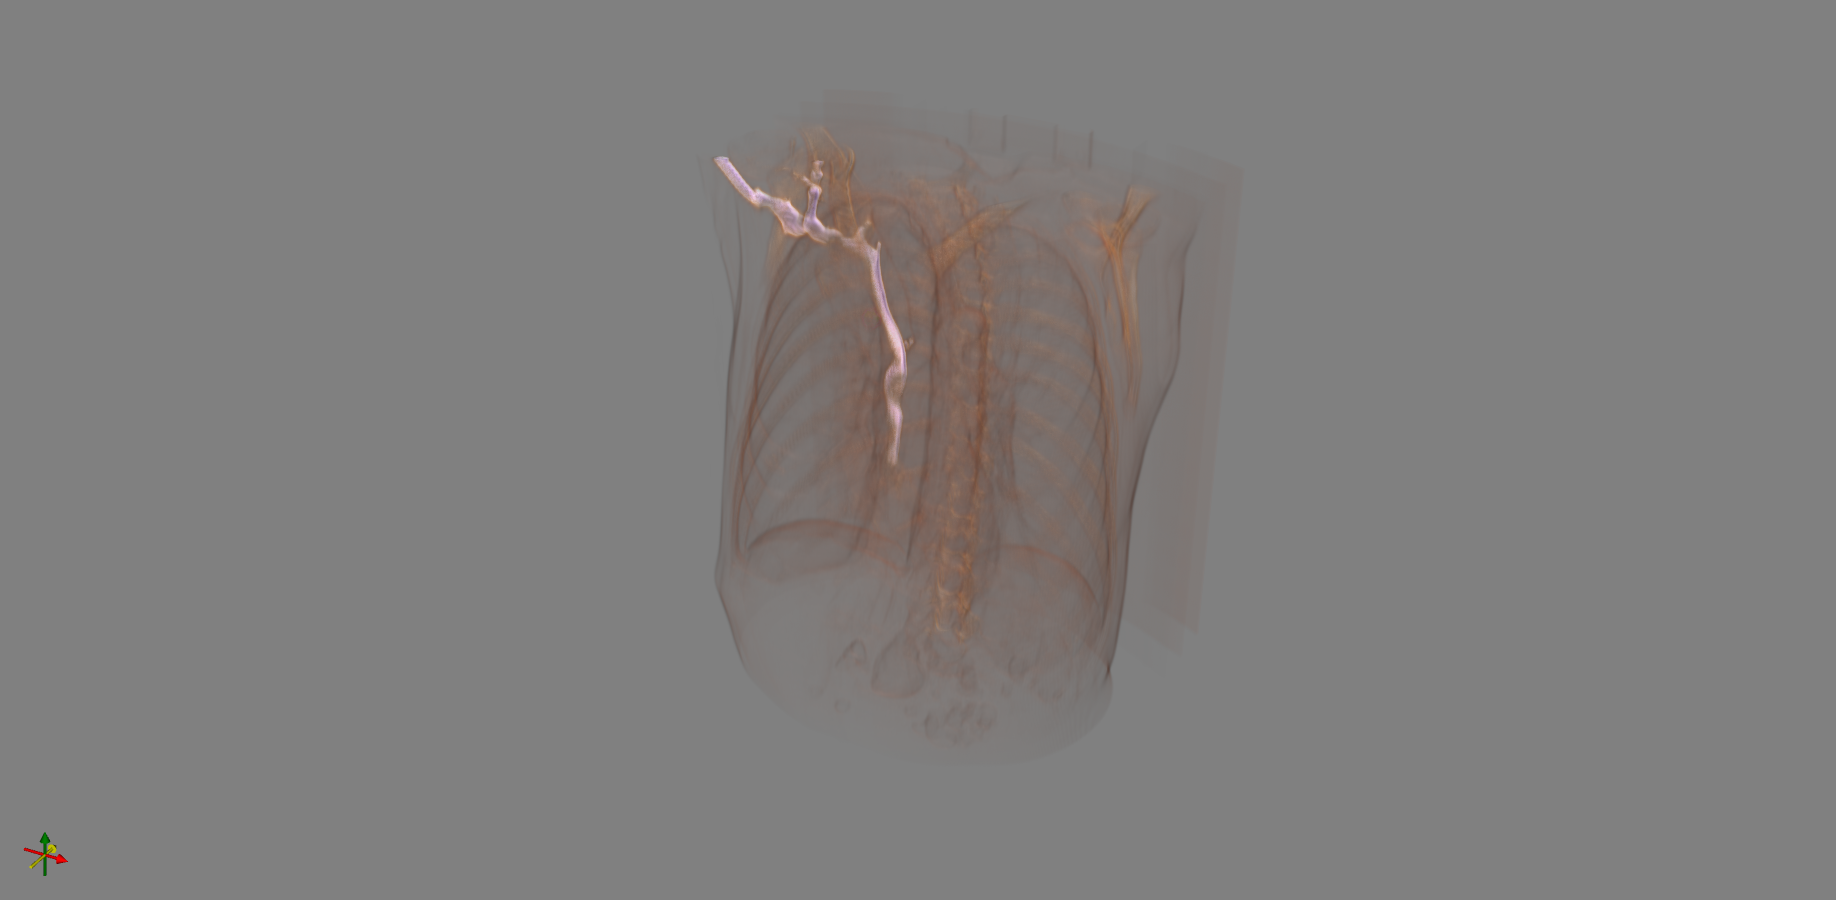
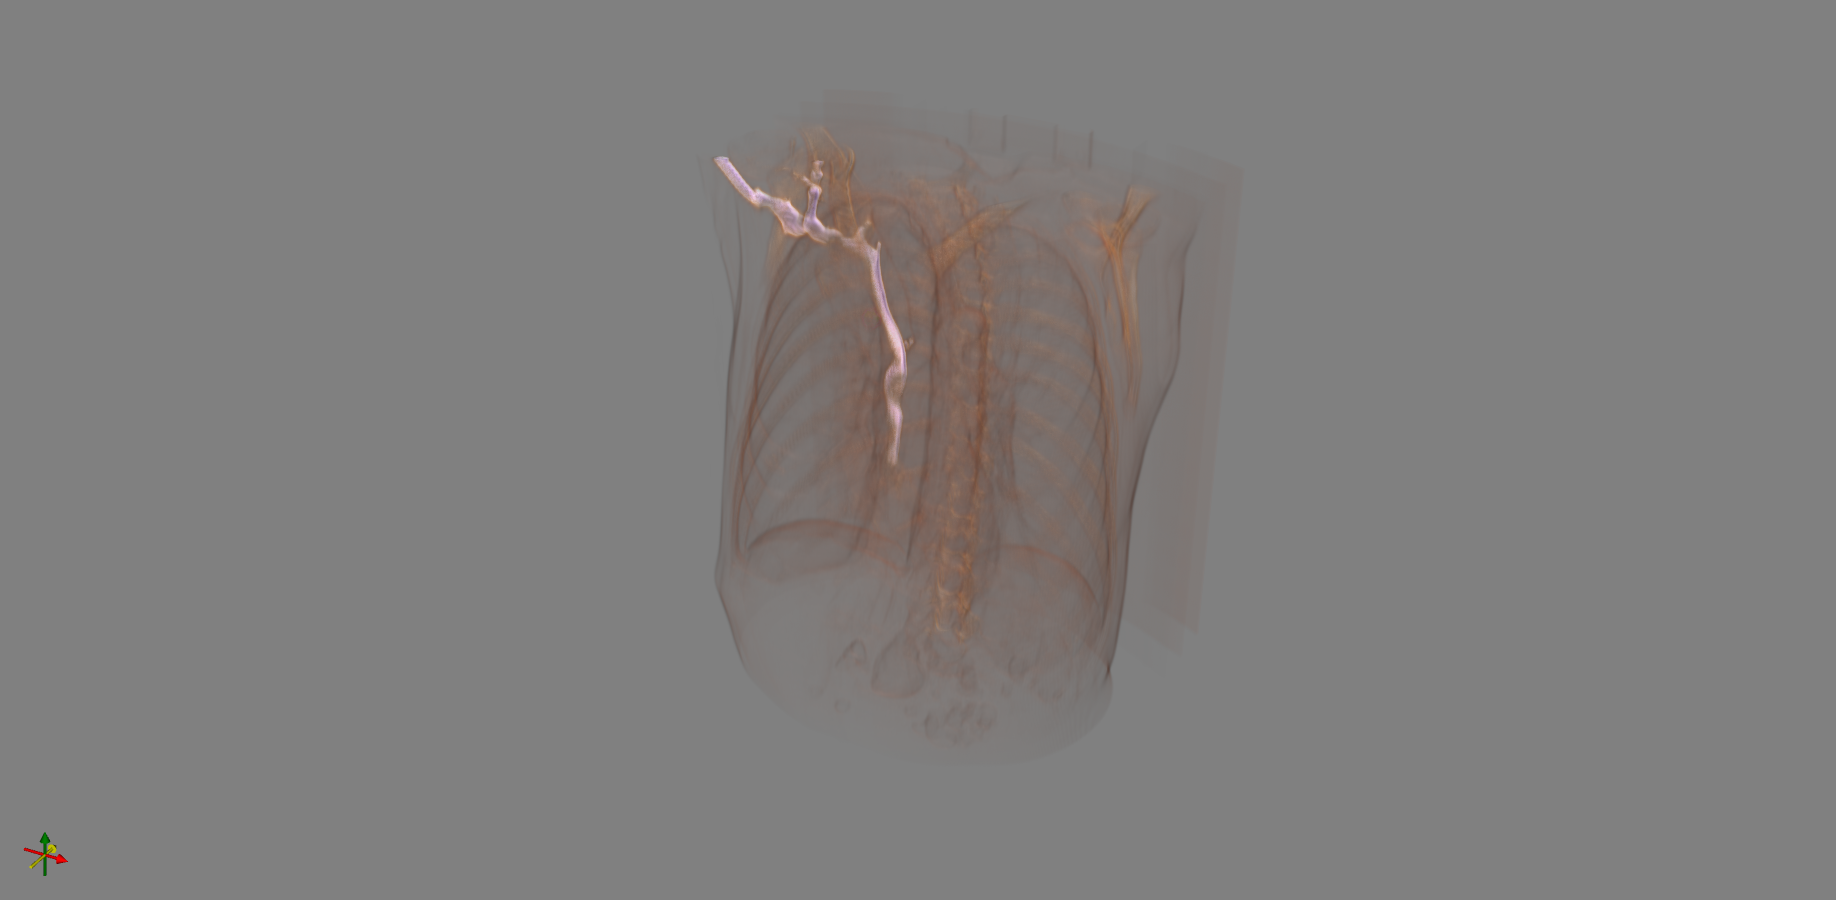

<IPython.core.display.Javascript object>

In [22]:
viewer2 = view(image=ct_img, label_image=seg_img_sum)

In [23]:
viewer2.set_image_color_map("CT-Chest-Vessels")
viewer2.set_image_color_range([0,400])
viewer2.set_view_mode("Volume")
viewer2.set_ui_collapsed(False)
viewer2.set_label_image_weights([0.5,1])
viewer2.set_image_gradient_opacity_scale(0.01)

In [24]:
viewer2.set_image_color_map("Grayscale")
viewer2.set_image_color_range([0,400])
viewer2.set_label_image_blend(0.99)
viewer2.set_view_mode("ZPlane")
viewer2.set_z_slice(353)
viewer2.set_ui_collapsed(False)